# Streaming TimeSeries prediction using SPSS Flow deployed in WML

**(C) 2019 IBM - Philippe Gregoire - Ecosystem Advocacy Group Europe - Partners Technical Enablement**

## Prerequisites:
* A SPSS Flow with a Streaming Time Series node must be deployed to Watson Machine Learning
* An input file in CSV format with columns matching the deployed WML SPSS model must be present in Cloud Object Storage

## Operations
* We first load the CSV file from COS into a pandas DataFrame, `df_data`
* That dataframe is converted to an array of rows, each row itself being an array or individual values.
* We initialize the WML client with the WML credentials where that model is deployed.
* The array of timeseries values is fed into a WML prediction call
* The predictions are returned in JSON-formatted text
* We convert the text to JSON (Python dictionary) and then back to a Results DataFrame
* The predictions DataFrame is then stored in a new file in COS

## Notes
* Here we assume that the input CSV file has been created in COS from its DB2 data source tables, using a Data refinery flow that has joined the two
* We could also connect directly to the DB2 tables and build the dataframe from there rather than going through COS

## insert input data asset credentials
* Place our cursor in the code cell below, remove the existing code.
* Use the 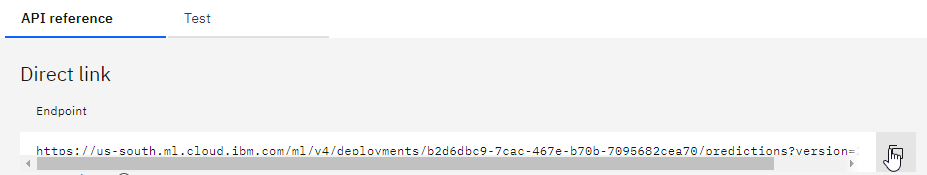menu at the top right, to open the data pane, then locate the `broadband.csv` file and select *Insert to code->Crednetials* 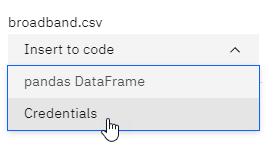
* rename `credentials_x` variable to `cos_credentials`

In [ ]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
cos_credentials = {
    'IAM_SERVICE_ID': 'iam-ServiceId-0e02e885-b393-4b2d-b72d-4512f4ac82e5',
    'IBM_API_KEY_ID': 'INSERT YOUR OWN',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'streamingtslab-donotdelete-pr-eiarcmwm96atvm',
    'FILE': 'broadband.csv'
}

## Enter IAM token
In a separate tab, navigate to https://cloud.ibm.com/iam/apikeys, then click 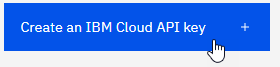, give it a name, e.g. `Market_APIKey`, copy to clipboard 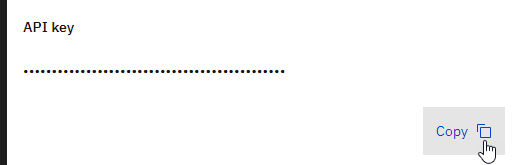 and paste the value in the cell below, surrounded by quotes

In [ ]:
IAM_APIKEY='INSERT YOUR OWN'

## Set WML location
We assume your WML service runs within `us-south` region, if not change it below (`eu-gb`, `eu-de`)

In [ ]:
wml_location='us-south'

In [ ]:
# Setup some constants
# Name of the timestamp field/column
key_ts='DATE_'
# Number of Markets
MarketMax=85
# Name of WML model
TSModelName='Online_Market_Predict'

In [ ]:
# Get the data from the joined COS table object, using the credentials from above
import types
import numpy as np
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cos_credentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=cos_credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['ENDPOINT'])

body = cos.get_object(Bucket=cos_credentials['BUCKET'],Key=cos_credentials['FILE'])['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# Read the input Time Series file
df_ts = pd.read_csv(body)

In [ ]:
# Adjust types, so that we can sort on timestamp
df_ts[key_ts]=pd.to_datetime(df_ts[key_ts])
# show some statistics
df_ts.dtypes.to_frame().transpose().append(df_ts.describe())

In [ ]:
# Order by timestamp
df_ts.sort_values(key_ts,inplace=True)
# Show the data
df_ts

In [ ]:
# plot Market_1 to market_5 after setting index to the DATE_ column
df_ts.set_index(key_ts)[['Market_{}'.format(x+1) for x in range(0,MarketMax)]].plot(figsize=(20,15));

In [ ]:
# Locate the WML model
# Load WML Client API
from ibm_watson_machine_learning import APIClient

wmlClient = APIClient({ "apikey": IAM_APIKEY,
                        "url": f"https://{wml_location}.ml.cloud.ibm.com" })
wmlClient.spaces.list(limit=10)
print('Select a space ID from the above list and paste it in the space_id= below')

In [ ]:
space_id='8e2de68b-dc4d-4234-bea8-79bbe5af8f66'

In [ ]:
# Find our model deployment
wmlClient.set.default_space(space_id)
deplRes=wmlClient.deployments.get_details()['resources']
depls=[d for d in deplRes if d['entity']['name']==TSModelName]
if len(depls)>0:
    depl=depls[0]
    depl_uid=wmlClient.deployments.get_uid(depl)
    depl_ent=depl['entity']
    print(f"Got deployment for model {TSModelName}")
else:
    print(f"Deployment with name {TSModelName} not found. Existing deployments: {[x['entity']['name'] for x in deplRes]}")

In [ ]:
# Get the model details
model_ent=wmlClient.repository.get_model_details(depl_ent['asset']['id'])['entity']
# Create a data frame structure that matches the model's 'input_data_schema'
input_columns=[x['name'] for x in model_ent['schemas']['input'][0]['fields']]
# Keep only the columns that are part of the model schema
df_ts=df_ts[input_columns]
# Convert date back to string to make it JSON serializable
df_ts[key_ts]=df_ts[key_ts].astype(str)
df_ts.head(2)

In [ ]:
# Score using the WML API directly on the dataframe
print(f"predicting with {df_ts.shape[0]} lines as input")
predictions = wmlClient.deployments.score(depl_uid, {"input_data":[{"values":df_ts}]})

In [ ]:
# Convert response back to dataframe
pred0=predictions['predictions'][0]
dfPredict=pd.DataFrame.from_records(pred0['values'],columns=pred0['fields'])
# Convert TS column
dfPredict[key_ts]=pd.to_datetime(dfPredict[key_ts],format="%Y-%m-%d %H:%M %p %Z")
dfPredict

In [ ]:
# Plot
dfPredict.set_index(key_ts).plot(figsize=(20,15));

In [ ]:
# plot each market
marketNum=4
for marketNum in range(1,6):
    marketCols=[key_ts]
    [marketCols.append(x) for x in dfPredict.columns if x.endswith('Market_{}'.format(marketNum)) and x.find("Residual")==-1]
    dfPredict[marketCols].set_index(key_ts).plot(figsize=(20,3));
    dfPredict[[key_ts,'$TSResidual-Market_{}'.format(marketNum)]].set_index(key_ts).plot(figsize=(20,1));

In [ ]:
# Write out the CSV data to a file object in COS
import io
cos.upload_fileobj(io.BytesIO(dfPredict.to_csv(encoding='utf-8').encode('utf-8')),cos_credentials['BUCKET'],"predicted_{}".format(cos_credentials['FILE']))